In [1]:
from use_existingmodels import test_depth_model

-> Loading model from  models\mono_640x192
   Loading pretrained encoder
   Loading pretrained decoder
-> Predicting on 1 test images
-> Done!


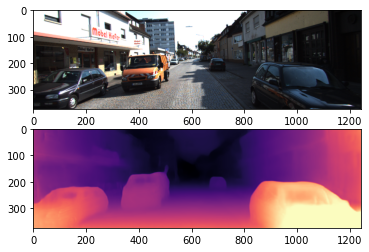

In [2]:
test_depth_model('data/kitti_example/2011_09_26/2011_09_26_drive_0048_sync/image_02/data/0000000000.png', 'mono_640x192', output_path='data', display_result = True, no_filesave = True)

In [3]:
# Path names
calib_path = "data/kitti_example/2011_09_26"
scene_path = os.path.join(calib_path, "2011_09_26_drive_0048_sync")

RGB_MAX_DIST = np.sqrt(3) * 255

# Set target and source for display
target = 11
source = 21

# Get transformation matrices
velo2cam = compute_image_from_velodyne_matrices(calib_path)["stereo_left"]
rel_pose = test_pose_model(os.path.join(scene_path, f"image_02/data/{target:010}.png"),os.path.join(scene_path, f"image_02/data/{source:010}.png"),  'mono+stereo_640x192')

# Set velodyne points
target_velodyne = load_lidar_points(os.path.join(scene_path, f"velodyne_points/data/{target:010}.bin"))
orig_colors = np.copy(target_velodyne[:, 3])
target_velodyne[:, 3] = 1

# Read in image files
img_tgt = np.array(Image.open(os.path.join(scene_path, f"image_02/data/{target:010}.png")))
img_src = np.array(Image.open(os.path.join(scene_path, f"image_02/data/{source:010}.png")))

-> Loading model from  models\mono+stereo_640x192
   Loading pretrained encoder
   Loading pretrained decoder
-> Predicting on relative pose for test images
-> Done!


[[ 9.9986756e-01 -6.2148194e-03 -1.5040869e-02  0.0000000e+00]
 [ 6.2413183e-03  9.9997908e-01  1.7154380e-03  0.0000000e+00]
 [ 1.5029892e-02 -1.8090871e-03  9.9988538e-01  0.0000000e+00]
 [-4.5529674e-03  6.1206141e-04 -2.5520355e-01  1.0000000e+00]]
[[73.089  6.952  2.692  1.   ]
 [73.166  7.191  2.695  1.   ]
 [72.539  7.705  2.676  1.   ]
 ...
 [ 3.745 -1.417 -1.751  1.   ]
 [ 3.765 -1.411 -1.758  1.   ]
 [ 3.789 -1.406 -1.769  1.   ]]
[[64.91316    6.493362   1.3490916  1.       ]
 [64.9917     6.7318726  1.351343   1.       ]
 [64.36771    7.249793   1.3426578  1.       ]
 ...
 [-4.540658  -1.4364651 -2.0647616  1.       ]
 [-4.520727  -1.4305768 -2.0720515  1.       ]
 [-4.4968653 -1.4257063 -2.0834026  1.       ]]


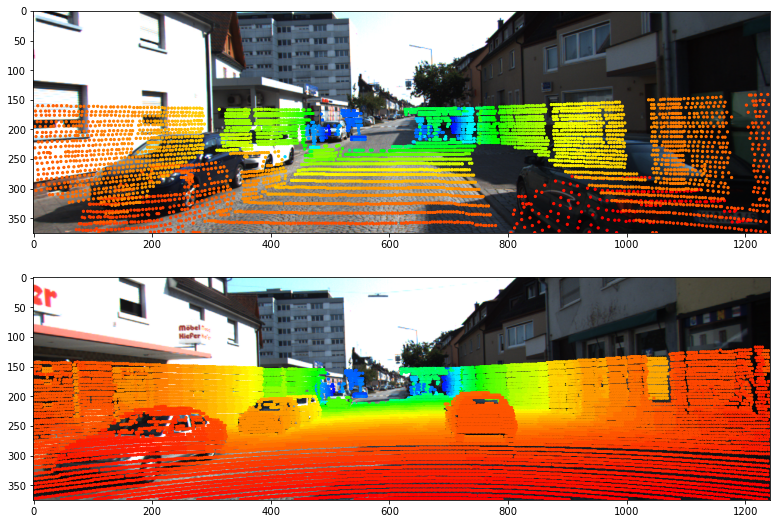

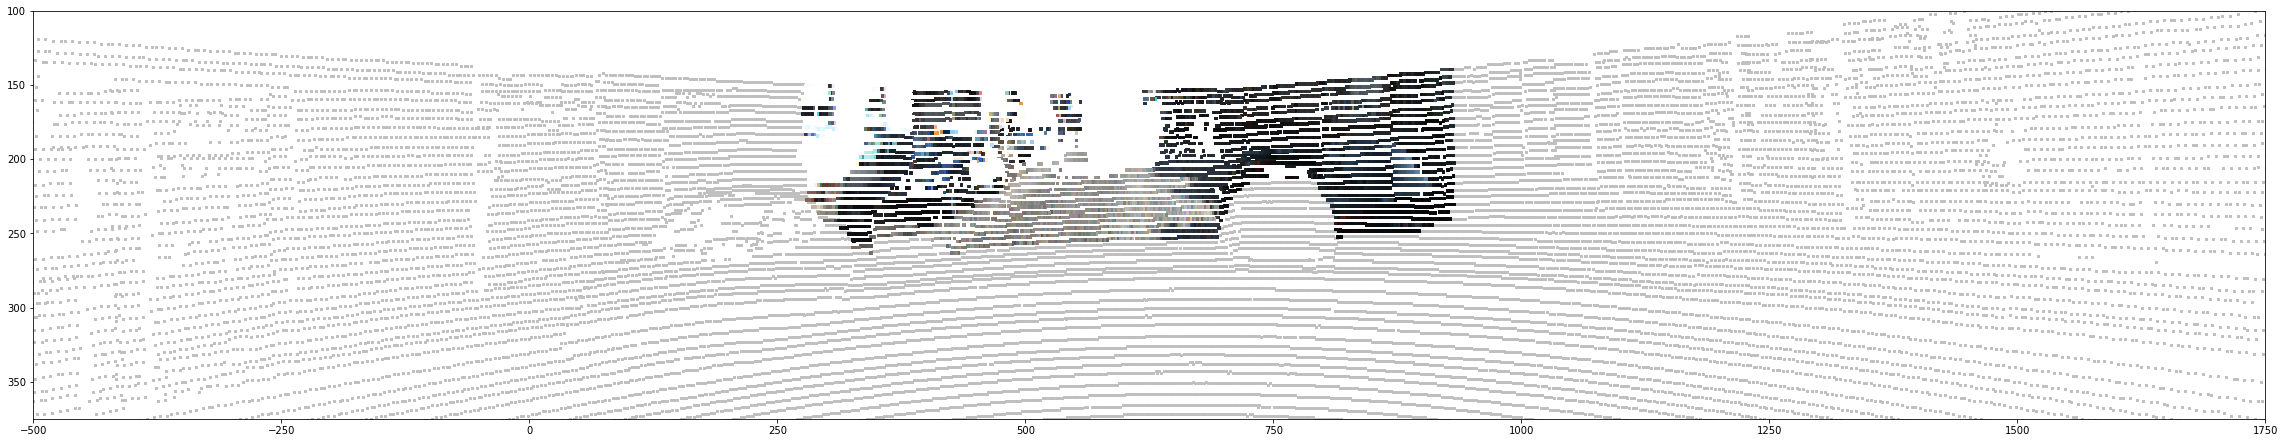

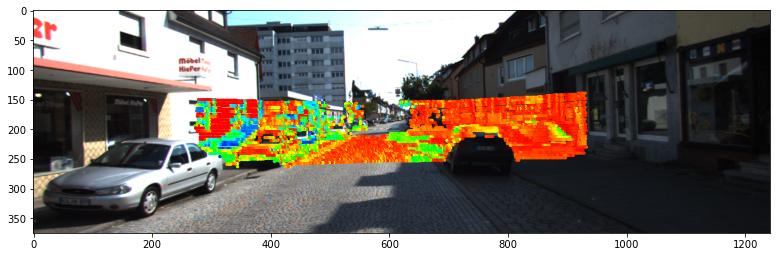

In [4]:
# Transform velodyne points into target and source camera planes
print(rel_pose.T)
rel_pose[0][3] = -8.25
transform_to_src = target_velodyne @ rel_pose.T
print(target_velodyne)
print(transform_to_src)
src_coord = filter_to_fov(filter_to_plane(project_points_on_image(transform_to_src, velo2cam)), img_src.shape)
tgt_coord = filter_to_fov(filter_to_plane(project_points_on_image(target_velodyne, velo2cam)), img_tgt.shape)

# Plot lidar points on each image
fig = plt.figure(figsize=(32, 9))
plot_lidar_on_image(img_src, src_coord, fig, 1)
plot_lidar_on_image(img_tgt, tgt_coord, fig, 2)

# Project source lidar points (with color from source image) into target frame
color_points, point_tgt_frame = color_target_points_with_source(target_velodyne, img_src, velo2cam, rel_pose)
plot_sparse_img_and_surrounding_lidar(point_tgt_frame, color_points[:, :4], color_points[:, 4:] / 255)

# Calculate photometric error for each velodyne point and plot on target image (blue is more error)
fig = plt.figure(figsize=(32, 9))
errors = calc_photo_error_velo(img_tgt, color_points) / RGB_MAX_DIST
plot_point_hue_on_image(img_tgt, color_points, errors, fig, 1)